Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# Version for filename
ver = 'GRU'
# Data allocation from 5 mouse No.
TRAIN = [1,2,3]
VALID = [4]
TEST = [5]

In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [4]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [5]:
# Clear session
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [6]:
# Set Seed
SEED = 123

import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'

import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(SEED)
rn.seed(SEED)
tf.set_random_seed(SEED)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tfdeterminism import patch
patch()

TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


In [7]:
# Load data
signal = io.loadmat('../data/signal_5mice_raw.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [8]:
plt.rcParams["font.size"] = 18

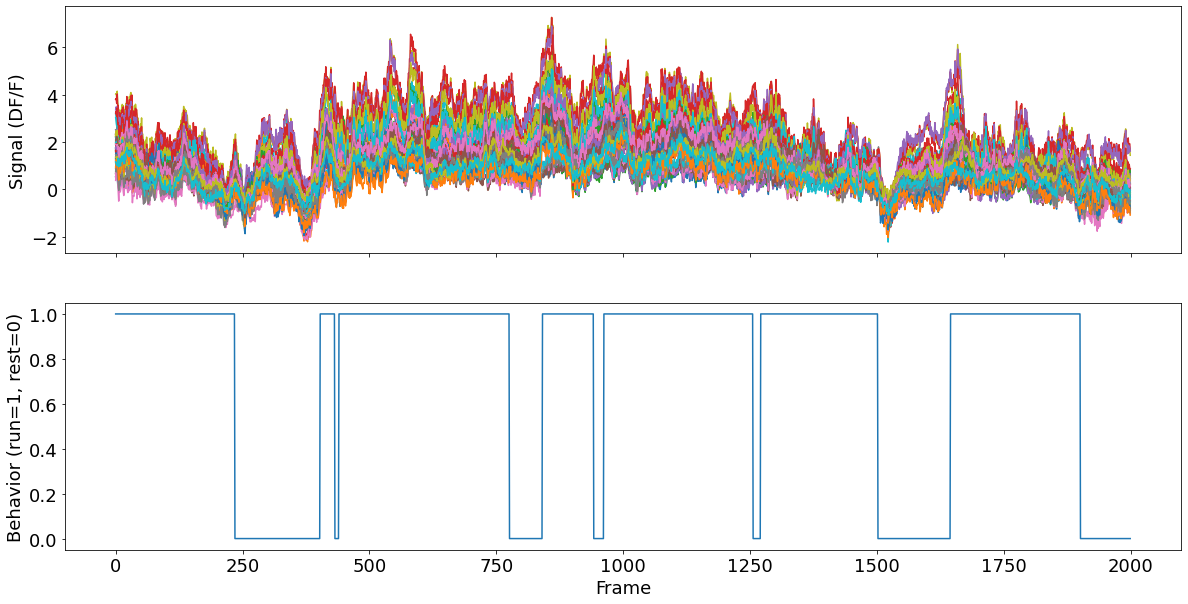

In [9]:
# Example of data
i = 2 # mouse No.
j = 5 # experiment No.
range_start = 10000
range_end = 12000
s = signal['signal'+str(i)][0,j-1]
b = runrest['runrest'+str(i)][0,j-1]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 10))
plt.xlabel("Frame")
ax[0].plot(s[:,range_start:range_end].transpose())
ax[0].set(ylabel="Signal (DF/F)")
ax[1].plot(b[:,range_start:range_end].transpose())
ax[1].set(ylabel="Behavior (run=1, rest=0)")
plt.show()

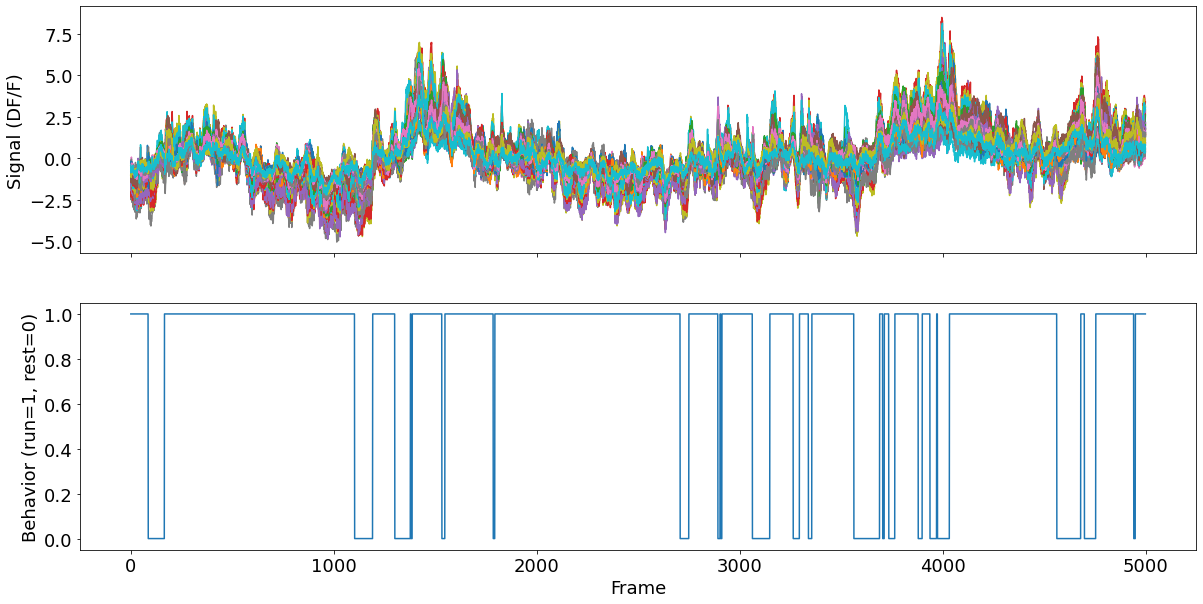

In [10]:
# Example of data
i = 3 # mouse No.
j = 2 # experiment No.
range_start = 10000
range_end = 15000
s = signal['signal'+str(i)][0,j-1]
b = runrest['runrest'+str(i)][0,j-1]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 10))
plt.xlabel("Frame")
ax[0].plot(s[:,range_start:range_end].transpose())
ax[0].set(ylabel="Signal (DF/F)")
ax[1].plot(b[:,range_start:range_end].transpose())
ax[1].set(ylabel="Behavior (run=1, rest=0)")
plt.show()

# Preprocess

In [11]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [12]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [13]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Label proportion
    print('The positive proportion is {:.2f}'.format(runrest.sum() / runrest.shape[0]))
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [14]:
# Training dataset
trainX = numpy.empty([0,50,31], dtype=numpy.float32)
trainY = numpy.empty(0, dtype=numpy.float32)
for i in TRAIN:
    print(f'Mouse {i}')
    for j in range(signal['signal'+str(i)].shape[1]):
        X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
        trainX = numpy.concatenate([trainX, X], axis=0)
        trainY = numpy.concatenate([trainY, Y], axis=0)

Mouse 1
The positive proportion is 0.41
The positive proportion is 0.43
The positive proportion is 0.40
The positive proportion is 0.46
The positive proportion is 0.37
The positive proportion is 0.46
The positive proportion is 0.27
The positive proportion is 0.41
The positive proportion is 0.24
The positive proportion is 0.25
The positive proportion is 0.33
Mouse 2
The positive proportion is 0.51
The positive proportion is 0.31
The positive proportion is 0.42
The positive proportion is 0.89
The positive proportion is 0.87
The positive proportion is 0.82
The positive proportion is 0.75
The positive proportion is 0.74
The positive proportion is 0.91
The positive proportion is 0.84
The positive proportion is 0.48
The positive proportion is 0.37
Mouse 3
The positive proportion is 0.79
The positive proportion is 0.87
The positive proportion is 0.83
The positive proportion is 0.81
The positive proportion is 0.84
The positive proportion is 0.67
The positive proportion is 0.67
The positive pro

In [15]:
# Validation dataset
validX = numpy.empty([0,50,31], dtype=numpy.float32)
validY =numpy.empty(0, dtype=numpy.float32)
for i in VALID:
    print(f'Mouse {i}')
    for j in range(signal['signal'+str(i)].shape[1]):
        X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
        validX = numpy.concatenate([validX, X], axis=0)
        validY = numpy.concatenate([validY, Y], axis=0)

Mouse 4
The positive proportion is 0.36
The positive proportion is 0.41
The positive proportion is 0.65
The positive proportion is 0.60
The positive proportion is 0.56
The positive proportion is 0.60
The positive proportion is 0.47
The positive proportion is 0.75
The positive proportion is 0.59
The positive proportion is 0.49
The positive proportion is 0.65
The positive proportion is 0.69
The positive proportion is 0.63
The positive proportion is 0.67
The positive proportion is 0.63


In [16]:
# Test dataset
testX = numpy.empty([0,50,31], dtype=numpy.float32)
testY = numpy.empty(0, dtype=numpy.float32)
for i in TEST:
    print(f'Mouse {i}')
    for j in range(signal['signal'+str(i)].shape[1]):
        X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
        testX = numpy.concatenate([testX, X], axis=0)
        testY = numpy.concatenate([testY, Y], axis=0)

Mouse 5
The positive proportion is 0.94
The positive proportion is 0.95
The positive proportion is 0.83
The positive proportion is 0.77
The positive proportion is 0.78
The positive proportion is 0.75
The positive proportion is 0.80
The positive proportion is 0.78
The positive proportion is 0.85
The positive proportion is 0.72
The positive proportion is 0.82
The positive proportion is 0.64


In [17]:
print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(664890, 50, 31)
(664890,)
(269550, 50, 31)
(269550,)
(215640, 50, 31)
(215640,)


# Deep Learning

In [18]:
# Transpose input
input_train = trainX.transpose(0,2,1)
input_valid = validX.transpose(0,2,1)
input_test = testX.transpose(0,2,1)
print(input_train.shape)
print(input_valid.shape)
print(input_test.shape)

(664890, 31, 50)
(269550, 31, 50)
(215640, 31, 50)


In [19]:
# Callback Setting
model_file_path = f'model/best_model_{ver}.h5'
modelCheckpoint = ModelCheckpoint(filepath = model_file_path,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  save_freq="epoch")

In [20]:
# Create and fit the LSTM network
output_dim = 32 #This is determined by the complexity of the model.
model = Sequential()
model.add(GRU(output_dim, input_shape=(2*look_frame+1, trainX.shape[1])))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss=losses.BinaryCrossentropy(label_smoothing=0.001), optimizer='adam', metrics=['accuracy'])
history = model.fit(x=input_train, y=trainY, validation_data=(input_valid, validY),
                    epochs=30, batch_size=256, verbose=1, callbacks=[modelCheckpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                7968      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________
Train on 664890 samples, validate on 269550 samples
Epoch 1/30
664832/664890 [============================>.] - ETA: 0s - loss: 0.3434 - acc: 0.8549
Epoch 00001: val_loss improved from inf to 0.56652, saving model to model/best_model_GRU.h5
664890/664890 [==============================] - 69s 104us/sample - loss: 0.3433 - acc: 0.8549 - val_loss: 0.5665 - val_acc: 0.7863
Epoch 2/30
664832/664890 [============================>.] - ETA: 0s - loss: 0.2499 - acc: 0.9032
Epoch 00002: val_loss improved from 0.56652 to

Epoch 27/30
664320/664890 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9557
Epoch 00027: val_loss improved from 0.35425 to 0.34362, saving model to model/best_model_GRU.h5
664890/664890 [==============================] - 62s 94us/sample - loss: 0.1158 - acc: 0.9557 - val_loss: 0.3436 - val_acc: 0.8828
Epoch 28/30
664576/664890 [============================>.] - ETA: 0s - loss: 0.1132 - acc: 0.9569
Epoch 00028: val_loss improved from 0.34362 to 0.29637, saving model to model/best_model_GRU.h5
664890/664890 [==============================] - 61s 92us/sample - loss: 0.1132 - acc: 0.9569 - val_loss: 0.2964 - val_acc: 0.8947
Epoch 29/30
664576/664890 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9575
Epoch 00029: val_loss did not improve from 0.29637
664890/664890 [==============================] - 62s 93us/sample - loss: 0.1112 - acc: 0.9575 - val_loss: 0.3116 - val_acc: 0.8864
Epoch 30/30
664576/664890 [============================>.] - ETA: 0s -

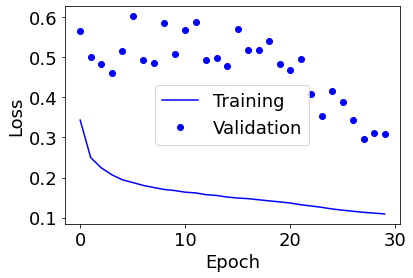

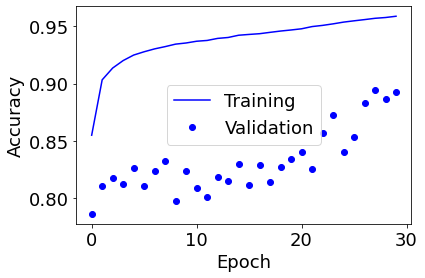

In [21]:
# Plot learning result
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'bo', label='Validation')
#plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'bo', label='Validation')
#plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
# Calcurate accuracy
model = load_model(model_file_path)
model.evaluate(input_test,testY)

215640/215640 [==============================] - 47s 219us/sample - loss: 0.2825 - acc: 0.9027


[0.2824568302169694, 0.9026804]

In [23]:
# Predict
train_pred = model.predict(input_train)
valid_pred = model.predict(input_valid)
test_pred = model.predict(input_test)

In [24]:
# Label
train_label = trainY
valid_label = validY
test_label = testY

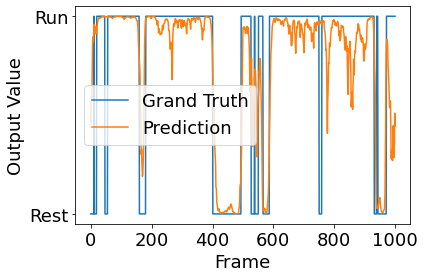

In [25]:
# Prediction and Label
range_start = 211000
range_end = 212000
plt.plot(test_label[range_start:range_end], label='Grand Truth')
plt.plot(test_pred[range_start:range_end], label='Prediction')
plt.xlabel("Frame")
plt.ylabel("Output Value")
plt.yticks(numpy.arange(0,2), ['Rest', 'Run'])
plt.legend()
plt.show()

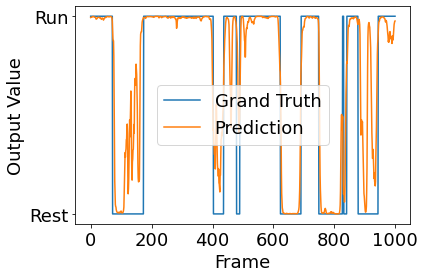

In [26]:
# Prediction and Label
range_start = 131000
range_end = 132000
plt.plot(test_label[range_start:range_end], label='Grand Truth')
plt.plot(test_pred[range_start:range_end], label='Prediction')
plt.xlabel("Frame")
plt.ylabel("Output Value")
plt.yticks(numpy.arange(0,2), ['Rest', 'Run'])
plt.legend()
plt.show()

In [27]:
# Save test rusult
io.savemat(f"result/test_result_{ver}.mat", {"test_label":test_label, "test_pred":test_pred})

In [28]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return fpr, tpr

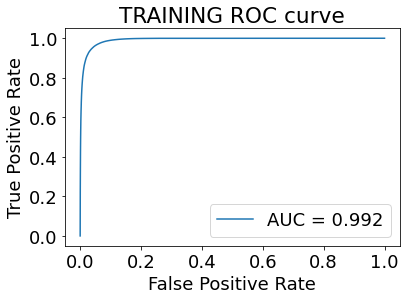

AUC: 0.992
Optimal threshold: 0.615


In [29]:
train_fpr, train_tpr = plot_roc(train_pred, train_label, "TRAINING")

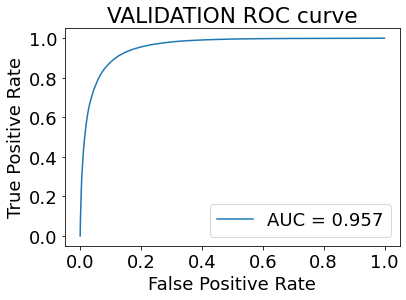

AUC: 0.957
Optimal threshold: 0.476


In [30]:
valid_fpr, valid_tpr = plot_roc(valid_pred, valid_label, "VALIDATION")

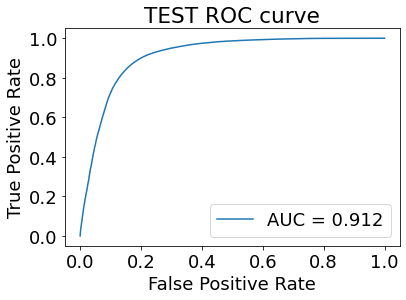

AUC: 0.912
Optimal threshold: 0.854


In [31]:
test_fpr, test_tpr = plot_roc(test_pred, test_label, "TEST")

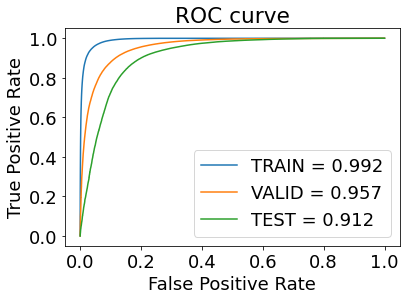

In [32]:
AUC = roc_auc_score(train_label, train_pred)
plt.plot(train_fpr, train_tpr, label="TRAIN = {:.3f}".format(AUC))
AUC = roc_auc_score(valid_label, valid_pred)
plt.plot(valid_fpr, valid_tpr, label="VALID = {:.3f}".format(AUC))
AUC = roc_auc_score(test_label, test_pred)
plt.plot(test_fpr, test_tpr, label="TEST = {:.3f}".format(AUC))
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()